In [5]:
import pyscf
import ctypes
import numpy as np
from pyscf import dft
from pyscf import gto
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from pyscf import lib
from pyscf.dft import libxc
from pyscf.dft import numint
from pyscf.dft import xc_deriv

In [6]:
#LDA relies on getting the density from the grid, so need to make a grid. 
#want to modify the matplot defaults to better fit
import matplotlib as mpl
#psi4 tutorial values
mpl.rcParams["font.size"]=14
mpl.rcParams["text.color"]="grey"
mpl.rcParams["font.family"]="sans-serif"
mpl.rcParams["axes.edgecolor"]="#eae8e9"


In [7]:
#Before building a grid, need to do a regular calculation and build the H2 molecule

mol=gto.Mole()
mol.atom='''
    H 0 0 -1
    H 0 0 1
'''
#H2 on z-axis, cylindrical symmetry
mol.basis='cc-pvdz'
mol.symmetry=True
mol.build()
#no spin, since two electrons, so spin =0 - un-polarized system
#Run an SCF calculation with H2 to get total energy
mylda=dft.RKS(mol)
mylda.xc='lda,vwn' #for default LDA functionals, GGA would be type='gga', etc etc etc
mylda.kernel()


converged SCF energy = -0.973624043355693


np.float64(-0.9736240433556926)

In [8]:
#Now need to build the spherical grid
#grids are helpful to evaluate xc functional approx. (LDA)
#grid function will make a grid, get the weights from it
#default level is 3
grids=dft.gen_grid.Grids(mol)
#grids.level=3
grids.build(with_non0tab=True)


In [9]:
#grid built, retrieve components
weights = grids.weights #important for integrating and visualization
coords = grids.coords
newcoords = coords.T #transposing the matrix, flipping it on the diagonal, helps with calcs.
x,y,z = newcoords
#check coords (x, y, z)
print(x.shape, y.shape, z.shape) #dimensions of the matrix as a tuple (rows,columns)
#19616 rows

(19616,) (19616,) (19616,)


In [10]:
#Check coords again!! 
print(coords.shape[0]) #same as x
#shape[0] only returns # rows, not columns
print(coords)
print(newcoords.shape) #3 rows, 19616 columns
print(newcoords)

19616
[[-4.78914373 -4.78914373 -6.67886985]
 [-5.61840359 -5.61840359 -7.50812971]
 [-7.02641747 -7.02641747 -8.9161436 ]
 ...
 [ 8.05702634  8.05702634  6.16527061]
 [ 8.05702634  4.27554448  9.94675247]
 [ 4.27554448  8.05702634  9.94675247]]
(3, 19616)
[[-4.78914373 -5.61840359 -7.02641747 ...  8.05702634  8.05702634
   4.27554448]
 [-4.78914373 -5.61840359 -7.02641747 ...  8.05702634  4.27554448
   8.05702634]
 [-6.67886985 -7.50812971 -8.9161436  ...  6.16527061  9.94675247
   9.94675247]]


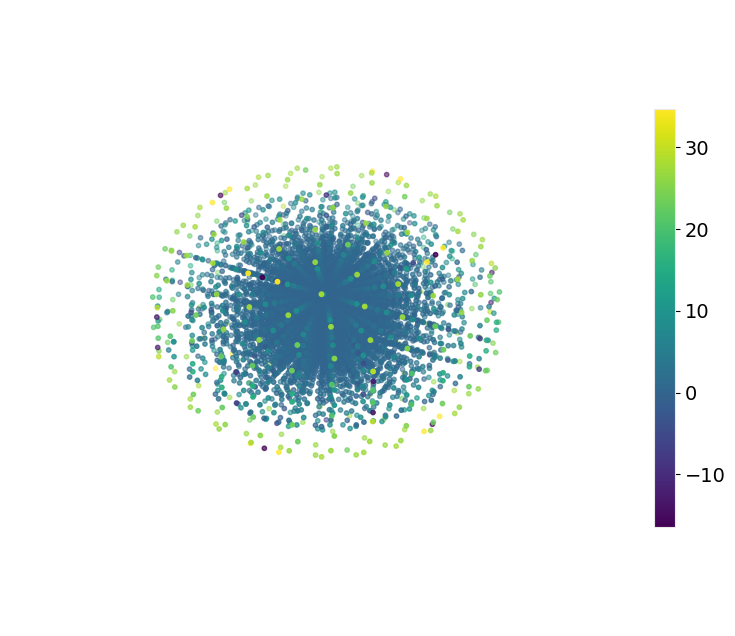

In [11]:
#Visualize the grid
fig = plt.figure(figsize=(9,8))
#ax = Axes3D(fig) #for 3D grid
ax = fig.add_subplot(projection='3d') #use this line to make a 3d graph
p = ax.scatter(x,y,z, c=weights, s=10)
ax.set_axis_off()
plt.colorbar(p, fraction=0.030, pad=0.04)


In [12]:
#Densier grid (higher level)

grids = dft.gen_grid.Grids(mol)
grids.level=7
grids.build(with_non0tab=True)

100344


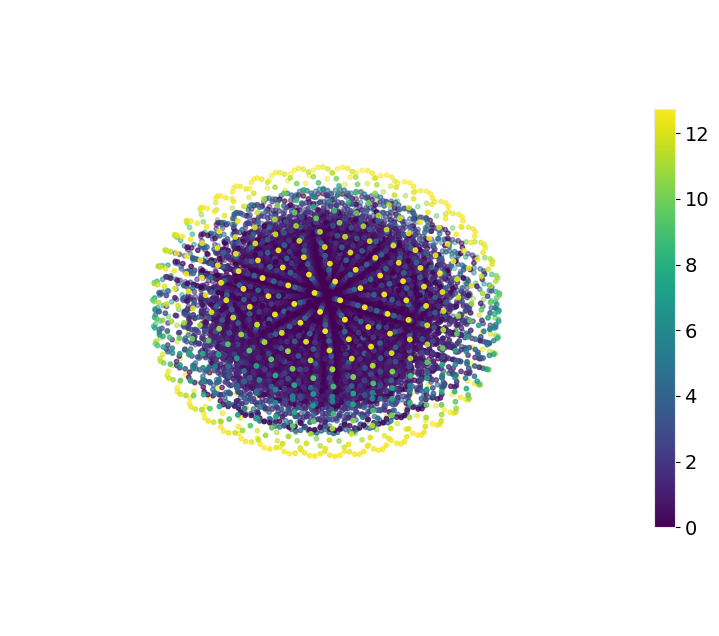

In [13]:
weights = grids.weights
coords = grids.coords
print(coords.shape[0]) #rows in the matrix
newcoords = coords.T #transpose
x, y, z = newcoords
fig = plt.figure(figsize=(9,8))
#ax = Axes3D(fig)
ax = fig.add_subplot(projection='3d')

ax.set_axis_off()
p = ax.scatter(x, y, z, c=weights, s=10)
plt.colorbar(p, fraction=0.030, pad=0.04)

In [22]:
#Try to get the density on the spherical grid
#first get the phi matrix on the grid >> AOs 

#Exchange correlation functionals are integrated over space, so need the grid representation for numerical integration to approx.
#For the numerical integration method, need density matrix as an input to get the density

#Make the density matrix
dm = mylda.make_rdm1()

#Evaluate AO values on the grid
ao_value_grid = numint.eval_ao(mol, coords, deriv=1) #AO value and its gradients
#first row of rho is electron density, the rest three rows are electron density gradients
#needed for the GGA functional
print("Density Matrix dimensions:",dm.shape)
print(ao_value_grid.shape) 
print("Phi matrix dimensions:", ao_value_grid[0].shape)

#Get the density and density gradients from grid
rho_grid = numint.eval_rho(mol, ao_value_grid, dm, xctype='GGA') #LDA doesn't do density gradients
print("rho_grid shape:",rho_grid.shape)
#Phi matrix and first derivative - which is which??
phi = ao_value_grid[0]
phix = ao_value_grid[1] #LDA only needs phix
phiy = ao_value_grid[2]
phiz = ao_value_grid[3]
#function - .nbas is the number of shells
#function = .nao_nr is the number of AO functions
#function - .ao_loc_nr() is how the ao functions are assigned to each shell


#LDA 2 outputs - energy[0] and potential[1] >> from grid
print('total # shells %d, total # Ao functions %d' %(mol.nbas, mol.nao_nr()))
print('ao function assignments to shells', mol.ao_loc_nr())


Density Matrix dimensions: (10, 10)
(4, 100344, 10)
Phi matrix dimensions: (100344, 10)
rho_grid shape: (4, 100344)
total # shells 6, total # Ao functions 10
ao function assignments to shells [ 0  1  2  5  6  7 10]


In [25]:
#Calculating density from grid by hand
#LDA only needs phix
rho = np.einsum('pm,mn,pn->p', phi,dm,phi, optimize=True) #rho: <p> = int(phi*dm*phi)
rhox = np.einsum('pm,mn,pn->p', phix,dm,phi)+np.einsum('pm,mn,pn->p',phi,dm,phix) #why two different integrals?
print('diff of rho_grid and rho:', rho-rho_grid[0])
print('difference of rhox and rho_grid[1]:',rhox-rho_grid[1])
#Which method is better?

diff of rho_grid and rho: [0. 0. 0. ... 0. 0. 0.]
difference of rhox and rho_grid[1]: [3.30872245e-24 4.13590306e-25 0.00000000e+00 ... 1.46936794e-39
 0.00000000e+00 0.00000000e+00]


In [67]:
#Define xc through libxc
#pbe xc function to approx. e-e i/a in a , composed of two parts
#ex = exchange correlation >> make a function to evaluate
#Two parts - (1) exchange, and, (2) correlation

#(1) exchange
def evalex(rho): #rho is the density matrix, as input
    ex=np.zeros(rho.shape[0]) #creates a new array of specified shapes and types filled with zeros
    #acts as a placeholder
    for i in range(rho.shape[0]):
        ex[i] = np.power(rho[i],1/3)*(-3/4)*(3/np.pi)**(1/3) #exchange correlation - energy density
    Ex=np.einsum('p,p,p->',ex,rho,weights) #capital E is for total, lower e is for indiv. on grid
    vx_rho = np.zeros(rho.shape[0])
    for j in range(rho.shape[0]):
        vx_rho[j]=ex[j]+rho[j]*(1/3)*np.power(rho[j],-2/3)*(-3/4)*(3/np.pi)**(1/3)
    V = np.einsum('pb,p,p,pa->ab', phi, vx_rho, weights, phi, optimize=True)
    return Ex, V #V is exchange potential



In [63]:
#(2) correlation
def evalc(rho):
    ni = numint.NumInt()
    ec = ni.eval_xc(",VWN", rho, spin=0, relativity=0, deriv=1)
    Ec = np.einsum('p,p,p->', ec[0], rho, weights)

    vc_list = ec[1]
    Vc = np.einsum('pb,p,p,pa->ab', phi, vc_list[0], weights, phi, optimize=True)
    return Ec, Vc


In [202]:
#Need to set up the hamiltonian for the SCF loop
ndocc = mol.nelectron // 2 #number of occupied orbitals, each with 2 electrons
#First, define variables
I = mol.intor('int2e') #ERI Tensor
S = mol.intor('int1e_ovlp') #Overlap matrix
#Diagonalize S
e_val, e_vec = np.linalg.eigh(S) #returns the eigenvalues[0] and eigenvectors[1] of a matrix
A = e_vec @ np.diag(e_val**-0.5) @ e_vec.T
#Core Hamiltonian
T = mol.intor('int1e_kin') #Kinetic
V = mol.intor('int1e_nuc') #potential
H = T+V
#Fock matrix
F_p = A.dot(H).dot(A)
print(H.shape)
e, C_p = np.linalg.eigh(F_p) #eigenvalues = e, eigenvectors = C_p
C = A.dot(C_p) #transforms the eigenvectors back to AO basis
C_occ = C[:, :ndocc] #occupied orbitals, used for density matrix
D =2* np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True) #times 2 bc 2 e- per orbital

print(D)

(10, 10)
[[ 3.23209608e-01  2.38580191e-01 -6.70831336e-17  4.74951434e-17
   2.82812888e-02  3.23209608e-01  2.38580191e-01 -2.80086182e-17
  -1.22402651e-17 -2.82812888e-02]
 [ 2.38580191e-01  1.76110196e-01 -4.95180415e-17  3.50589836e-17
   2.08760974e-02  2.38580191e-01  1.76110196e-01 -2.06748231e-17
  -9.03526600e-18 -2.08760974e-02]
 [-6.70831336e-17 -4.95180415e-17  1.39233077e-32 -9.85776092e-33
  -5.86986719e-18 -6.70831336e-17 -4.95180415e-17  5.81327359e-33
   2.54050412e-33  5.86986719e-18]
 [ 4.74951434e-17  3.50589836e-17 -9.85776092e-33  6.97933658e-33
   4.15589088e-18  4.74951434e-17  3.50589836e-17 -4.11582237e-33
  -1.79868770e-33 -4.15589088e-18]
 [ 2.82812888e-02  2.08760974e-02 -5.86986719e-18  4.15589088e-18
   2.47465197e-03  2.82812888e-02  2.08760974e-02 -2.45079292e-18
  -1.07104017e-18 -2.47465197e-03]
 [ 3.23209608e-01  2.38580191e-01 -6.70831336e-17  4.74951434e-17
   2.82812888e-02  3.23209608e-01  2.38580191e-01 -2.80086182e-17
  -1.22402651e-17 -2.828

In [215]:
#SCF Ieration Loop :)
E_old = 0.0 #to store the previous values
MAXITER = 40 #in case it doesn't converge
E_conv = 1.0e-8 #parameters
D_conv = 1.0e-6 #parameters

F_list = []
DIIS_RESID = []
#Begin loop
for i in range(1, MAXITER + 1):
    
    J = np.einsum('pqrs,rs->pq', I, D, optimize=True)
    rho2 = np.einsum('pm,mn,pn->p', phi, D/2, phi, optimize=True) #density from grid
    Ex, Vx = evalex(rho)
    Ec, Vc = evalc(rho)
    Exc = Ex + Ec
    Vxc = Vx + Vc
    
    F = H + J + Vxc #Fock 
    #print(J)
    F_list.append(F)
    #Components of the total SCF energy
    H_E = np.sum(D * H)
    J_E = 0.5*np.sum(D*J)
    #DIIS resid
    diis_r = A.dot(F.dot(D).dot(S) - S.dot(D).dot(F)).dot(A)
    DIIS_RESID.append(diis_r)
    #print(D)
    #SCF energy
    SCF_E = H_E + J_E + Exc + mol.energy_nuc() #total energy
    #Check difference
    diff_e = SCF_E - E_old
    dRMS = np.mean(diis_r**2)**0.5
    #Count iterations and keep track of values
    print("SCF Iteration %d: SCF Energy = %f, diff_E = %f, dRMS = %f" % (i, SCF_E, diff_e, dRMS))
    #create break sequence
    if (abs(diff_e) < E_conv) and (dRMS < D_conv):
        break
    #Redefine variables for next iteration
    E_old = SCF_E
    #Update DIIS for better convergence - B matrix 
    if i >=2:
        B_dim = len(F_list)+1
        B = np.empty((B_dim, B_dim))
        B[-1,:] = -1
        B[:,-1] = -1
        B[-1, -1] = 0
        for j in range(len(F_list)):
            for k in range(len(F_list)):
                B[j, k] = np.einsum('jk,jk->', DIIS_RESID[j], DIIS_RESID[k], optimize=True)
        #Pulay Equation
        rhs = np.zeros((B_dim))
        rhs[-1] = -1
        coeff = np.linalg.solve(B, rhs) # solve pulay w/ numpy
        F = np.zeros_like(F) #DIIS fock matrix
        
        for p in range(coeff.shape[0]-1):
            F += coeff[p] * F_list[p]
            
    F_p = A.dot(F).dot(A) #new orbital guess, using DIIS F matrix
    e, C_p = np.linalg.eigh(F_p)
    C = A.dot(C_p)
    C_occ = C[:, :ndocc]
    
    D = 2*np.einsum('pi,qi->pq', C_occ, C_occ, optimize=True)
    #D matrix improved upon for next iteration
    #Now failsafe in case doesn't converge
    
    if (i==MAXITER):
        raise Exception("Too many iterations before Convergence")
        
print("----")
print("SCF converged, final RHF Energy: %.8f Eh" %SCF_E)
print(f'Coulomb Energy: {J_E} Hartree')
print(f'Exchange-correlation energy: {Exc} Hartree')
print(f'Nuclear repulsion energy: {mol.energy_nuc()} Hartree')

SCF Iteration 1: SCF Energy = -0.973624, diff_E = -0.973624, dRMS = 0.000000
SCF Iteration 2: SCF Energy = -0.973624, diff_E = -0.000000, dRMS = 0.000000
----
SCF converged, final RHF Energy: -0.97362421 Eh
Coulomb Energy: 0.8508821933068768 Hartree
Exchange-correlation energy: -0.47999791476570225 Hartree
Nuclear repulsion energy: 0.26458860546 Hartree


In [235]:
#model calculation
model = dft.RKS(mol)
model.xc = 'lda,vwn'
model.kernel()
print('Exchange-correlation model:', model.get_veff().exc, 'Hartree')
print('Nuclear repulsion model:', model.energy_nuc(), 'Hartree')
print('Electronic Energy model:', model.energy_elec()[0], 'Hartree') #(Eelec, 2e- contribution)

converged SCF energy = -0.973624043355693
Exchange-correlation model: -0.47999752463996914 Hartree
Nuclear repulsion model: 0.26458860546 Hartree
Electronic Energy model: -1.2382126488156926 Hartree
